In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# 定义要处理的主题
train_subjects = ['Carpenter1_kd']
test_subjects = ['Masonry1_kd']

def load_and_preprocess_data(subject, label_mapping):
    """
    加载并预处理指定主题的数据。
    
    参数:
        subject (str): 主题名称
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 处理后的特征X和标签y
    """
    # 读取数据
    df = pd.read_csv(f'../{subject}.csv', low_memory=False)
    
    # 清除空值行
    df_cleaned = df.dropna()
    
    # 转换 'Label_2' 列为数值类型
    df_cleaned.loc[:, 'Label_2'] = pd.to_numeric(df_cleaned['Label_2'], errors='coerce')
    
    # 只选取前八个动作
    df_cleaned = df_cleaned[df_cleaned['Label_2'] <= 8]
    
    # 重新编码标签
    df_cleaned.loc[:, 'Label_2'] = df_cleaned['Label_2'].map(label_mapping)
    
    X = df_cleaned.drop(['Label_2','Subject'], axis=1)
    y = df_cleaned['Label_2']

    print(X.columns)

    # 设置窗口大小和步长
    window_size = 30
    step = 15  # 每次滑动窗口移动的步数

    # 创建一个空的DataFrame来存储滑动窗口处理后的结果
    X_rolled_list = []
    y_rolled_list = []

    # 对于X，创建滑动窗口并计算均值
    for i in range(0, len(X) - window_size + 1, step):
        X_window = X.iloc[i:i+window_size].rolling(window=window_size, min_periods=1).mean().iloc[-1]  # 取最后一个值
        X_rolled_list.append(X_window)

    # 对于y，创建滑动窗口并应用模式函数
    for i in range(0, len(y) - window_size + 1, step):
        y_window = y.iloc[i:i+window_size].rolling(window=window_size, min_periods=1).apply(
            lambda x: x.mode().iloc[0] if not x.isnull().all() else None, raw=False
        ).iloc[-1]  # 取最后一个值
        y_rolled_list.append(y_window)

    # 将列表转换为DataFrame/Series
    X_rolled = pd.DataFrame(X_rolled_list, columns=X.columns)
    y_rolled = pd.Series(y_rolled_list)

    # 特征标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_rolled)

    # 使用SMOTE处理类别不平衡
    smote = SMOTE(random_state=42)
    X_final, y_final = smote.fit_resample(X_rolled, y_rolled)

    # 将y标签修改成int
    y_final = y_final.astype(int) - 1

    return X_final, y_final

def prepare_datasets(train_subjects, test_subjects, label_mapping):
    """
    准备训练集和测试集。
    
    参数:
        train_subjects (list of str): 训练集主题列表
        test_subjects (list of str): 测试集主题列表
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 训练集特征、训练集标签、测试集特征、测试集标签
    """
    all_train_data = []
    all_test_data = []

    for subject in train_subjects + test_subjects:
        X, y = load_and_preprocess_data(subject, label_mapping)
        if subject in train_subjects:
            all_train_data.append((X, y))
        else:
            all_test_data.append((X, y))

    # 合并所有训练集和测试集数据
    X_train = pd.concat([x for x, _ in all_train_data], axis=0).values
    y_train = pd.concat([y for _, y in all_train_data], axis=0).values
    X_test = pd.concat([x for x, _ in all_test_data], axis=0).values
    y_test = pd.concat([y for _, y in all_test_data], axis=0).values

    return X_train, y_train, X_test, y_test

# 标签重编码映射
label_mapping = {1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 3, 7: 3, 8: 5}

# 准备数据集
X_train, y_train, X_test, y_test = prepare_datasets(train_subjects, test_subjects, label_mapping)

特征标准化（也称为归一化或缩放）通常是在数据预处理阶段进行的，目的是确保所有的特征都在相同的尺度上。这样做的好处是许多机器学习算法（尤其是基于梯度下降的优化算法）能够更快地收敛，并且对于一些对输入数据尺度敏感的算法（如SVM、KNN等）来说，标准化是非常重要的。

在你的代码流程中，特征标准化最好在处理完缺失值、滑动窗口之后，但在应用SMOTE等重采样技术之前进行。这是因为SMOTE和其他过采样方法依赖于特征空间中的距离来生成新的样本点，如果特征没有被标准化，那么特征尺度较大的维度将会主导这个距离的计算。

In [ ]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import imblearn as ib
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

# 定义要处理的主题
train_subjects = ['Carpenter1_kd']
test_subjects = ['Masonry1_kd']

def smote(X_train,y_train,subject):
    dim0=X_train.shape[0]
    dim1=X_train.shape[1]
    dim2=X_train.shape[2]
    X_trian_for_smote=np.reshape(X_train,(dim0,dim1*dim2))

    sme = SMOTETomek(random_state=42) 
    X_train_smo, y_train = sme.fit_resample(X_trian_for_smote, y_train)
    rus = RandomUnderSampler(random_state=42,sampling_strategy='majority')
    X_res, y_res = rus.fit_resample(X_trian_for_smote, y_train)
    if subject=="Carpenter1":
        smo = SMOTE(random_state=42,sampling_strategy={1:500,2:500})
    elif subject=="Carpenter2":
        smo = SMOTE(random_state=42,sampling_strategy={2:500})
    elif subject=="Masonry1" or "Masonry2":
        smo = SMOTE(random_state=42,sampling_strategy={1:300})
    elif subject=="Rebar1" or "Rebar2" or "Rebar3":
        smo = SMOTE(random_state=42,sampling_strategy={2:300,3:300})
    
    X_train_smo, y_train = smo.fit_resample(X_trian_for_smote, y_train)
    
    cnn = CondensedNearestNeighbour(random_state=42,sampling_strategy='majority')
    
    X_res, y_train = cnn.fit_resample(X_trian_for_smote, y_train ) 

    X_train=np.reshape(X_train_smo,(X_train_smo.shape[0],dim1,dim2))
    
    return X_train,y_train

def load_and_preprocess_data(subject, label_mapping):
    """
    加载并预处理指定主题的数据。
    
    参数:
        subject (str): 主题名称
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 处理后的特征X和标签y
    """
    # 读取数据
    df = pd.read_csv(f'../{subject}.csv', low_memory=False)
    
    # 清除空值行
    df_cleaned = df.dropna()
    
    # 转换 'Label_2' 列为数值类型
    df_cleaned.loc[:, 'Label_2'] = pd.to_numeric(df_cleaned['Label_2'], errors='coerce')
    
    # 只选取前八个动作
    df_cleaned = df_cleaned[df_cleaned['Label_2'] <= 8]
    
    # 重新编码标签
    df_cleaned.loc[:, 'Label_2'] = df_cleaned['Label_2'].map(label_mapping)
    
    X = df_cleaned.drop(['Label_2', 'Subject'], axis=1)
    y = df_cleaned['Label_2']

    print(X.columns)

    # 设置窗口大小和步长
    window_size = 30
    step = 15  # 每次滑动窗口移动的步数

    # 创建一个空的DataFrame来存储滑动窗口处理后的结果
    X_rolled_list = []
    y_rolled_list = []

    # 对于X，创建滑动窗口并计算均值
    for i in range(0, len(X) - window_size + 1, step):
        X_window = X.iloc[i:i+window_size].rolling(window=window_size, min_periods=1).mean().iloc[-1]  # 取最后一个值
        X_rolled_list.append(X_window)

    # 对于y，创建滑动窗口并应用模式函数
    for i in range(0, len(y) - window_size + 1, step):
        y_window = y.iloc[i:i+window_size].rolling(window=window_size, min_periods=1).apply(
            lambda x: x.mode().iloc[0] if not x.isnull().all() else None, raw=False
        ).iloc[-1]  # 取最后一个值
        y_rolled_list.append(y_window)

    # 将列表转换为DataFrame/Series
    X_rolled = pd.DataFrame(X_rolled_list, columns=X.columns)
    y_rolled = pd.Series(y_rolled_list)

    # 特征标准化
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_rolled)

    # 使用新的smote函数处理类别不平衡
    X_final, y_final = smote(X_rolled.values.reshape(-1, 1, X_rolled.shape[1]), y_rolled, subject)

    # 将y标签修改成int
    y_final = y_final.astype(int) - 1

    return X_final, y_final

def prepare_datasets(train_subjects, test_subjects, label_mapping):
    """
    准备训练集和测试集。
    
    参数:
        train_subjects (list of str): 训练集主题列表
        test_subjects (list of str): 测试集主题列表
        label_mapping (dict): 标签重编码映射
    
    返回:
        tuple: 训练集特征、训练集标签、测试集特征、测试集标签
    """
    all_train_data = []
    all_test_data = []

    for subject in train_subjects + test_subjects:
        X, y = load_and_preprocess_data(subject, label_mapping)
        if subject in train_subjects:
            all_train_data.append((X, y))
        else:
            all_test_data.append((X, y))

    # 合并所有训练集和测试集数据
    X_train = pd.concat([x for x, _ in all_train_data], axis=0).values
    y_train = pd.concat([y for _, y in all_train_data], axis=0).values
    X_test = pd.concat([x for x, _ in all_test_data], axis=0).values
    y_test = pd.concat([y for _, y in all_test_data], axis=0).values

    return X_train, y_train, X_test, y_test

# 标签重编码映射
label_mapping = {1: 1, 2: 2, 3: 3, 4: 3, 5: 4, 6: 3, 7: 3, 8: 5}

# 准备数据集
X_train, y_train, X_test, y_test = prepare_datasets(train_subjects, test_subjects, label_mapping)

Index(['Accelerometer.xlsx_z', 'Accelerometer.xlsx_y', 'Accelerometer.xlsx_x',
       'Gravity_z', 'Gravity_y', 'Gravity_x', 'Gyroscope_z', 'Gyroscope_y',
       'Gyroscope_x', 'Magnetometer_z', 'Magnetometer_y'],
      dtype='object')


IndexError: index 4954 is out of bounds for axis 0 with size 4954

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title, save_path):
    """
    绘制混淆矩阵图。
    
    参数:
        y_true (array-like): 真实标签
        y_pred (array-like): 预测标签
        labels (list of str): 分类标签
        title (str): 图标题
        save_path (str): 保存图片路径
    """
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path, dpi=300)

In [ ]:
import imblearn as ib
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour

def smote(X_train,y_train,subject):
    dim0=X_train.shape[0]
    dim1=X_train.shape[1]
    dim2=X_train.shape[2]
    X_trian_for_smote=np.reshape(X_train,(dim0,dim1*dim2))

    # sme = SMOTETomek(random_state=42) 这个SMOTEomek用来删除少
    # X_train_smo, y_train = sme.fit_resample(X_trian_for_smote, y_train)
    # rus = RandomUnderSampler(random_state=42,sampling_strategy='majority')
    # X_res, y_res = rus.fit_resample(X_trian_for_smote, y_train)
    if subject=="Carpenter1":
        smo = SMOTE(random_state=42,sampling_strategy={1:500,2:500})
    elif subject=="Carpenter2":
        smo = SMOTE(random_state=42,sampling_strategy={2:500})
    # elif subject=="Masonry1" or "Masonry2":
        # smo = SMOTE(random_state=42,sampling_strategy={1:300})
    elif subject=="Rebar1" or "Rebar2" or "Rebar3":
        smo = SMOTE(random_state=42,sampling_strategy={2:300,3:300})
    X_train_smo, y_train = smo.fit_resample(X_trian_for_smote, y_train)
    # cnn = CondensedNearestNeighbour(random_state=42,sampling_strategy='majority')
    # X_res, y_train = cnn.fit_resample(X_trian_for_smote, y_train ) 
    X_train=np.reshape(X_train_smo,(X_train_smo.shape[0],dim1,dim2))
    return X_train,y_train


In [9]:
from catboost import CatBoostClassifier
from catboost import Pool

# 定义CatBoost参数
catboost_params = {
    'iterations': 500,
    'depth': 4,
    'learning_rate': 0.1,
    'l2_leaf_reg': 3,
    'bagging_temperature': 0.9,
    'random_strength': 0.1,
    'one_hot_max_size': 2,
    'loss_function': 'MultiClass',
    'eval_metric': 'Accuracy',
    'early_stopping_rounds': 10,
    'verbose': 0  # 设置verbose为0以减少输出信息
}

catboost_clf = CatBoostClassifier(**catboost_params)

catboost_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])


In [10]:
y_pred_ = catboost_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_)
print(f"Accuracy of the original model: {accuracy:.4f}")

Accuracy of the original model: 0.5630


In [12]:
# 保存原始模型
catboost_clf.save_model('original_model.cbm')

In [13]:
# 加载预训练的模型
pretrained_model = CatBoostClassifier()
pretrained_model.load_model('original_model.cbm')

# 定义新的 CatBoost 分类器
fine_tuned_model = CatBoostClassifier(
    iterations=100,  # 新的迭代次数
    learning_rate=0.05,  # 较小的学习率
    depth=6,
    loss_function='MultiClass',  # 根据你的任务选择合适的损失函数
    random_seed=42,
    verbose=False  # 关闭日志输出
)

# 定义Pool对象
pool = Pool(X_test, label=y_test)

# 使用预训练模型继续训练
fine_tuned_model.fit(
    pool,  # 使用Pool对象
    eval_set=None,  # 如果不需要验证集，可以设置为 None
    init_model=pretrained_model  # 指定预训练模型
)

# 评估模型
y_pred = fine_tuned_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the fine-tuned model: {accuracy:.4f}")


Accuracy of the fine-tuned model: 0.8256


In [6]:
# 保存微调后的模型
fine_tuned_model.save_model('fine_tuned_model.cbm')

In [ ]:
feature_label = ['Accelerometer.xlsx_z', 'Accelerometer.xlsx_y', 'Accelerometer.xlsx_x',
       'Gravity_z', 'Gravity_y', 'Gravity_x', 'Gyroscope_z', 'Gyroscope_y',
       'Gyroscope_x', 'Magnetometer_z', 'Magnetometer_y']

In [14]:

# 获取特征重要性
feature_importance = fine_tuned_model.get_feature_importance(pool)
# 打印特征重要性
print("Feature Importance:", feature_importance)


feature_label = ['Accelerometer.xlsx_z', 'Accelerometer.xlsx_y', 'Accelerometer.xlsx_x',
       'Gravity_z', 'Gravity_y', 'Gravity_x', 'Gyroscope_z', 'Gyroscope_y',
       'Gyroscope_x', 'Magnetometer_z', 'Magnetometer_y']

Feature Importance: [ 4.36656169  4.9274813   4.26237076 19.37230824 24.92758035  7.8077476
  3.56071269  2.03110177  4.28327771  6.11731646 18.34354141]


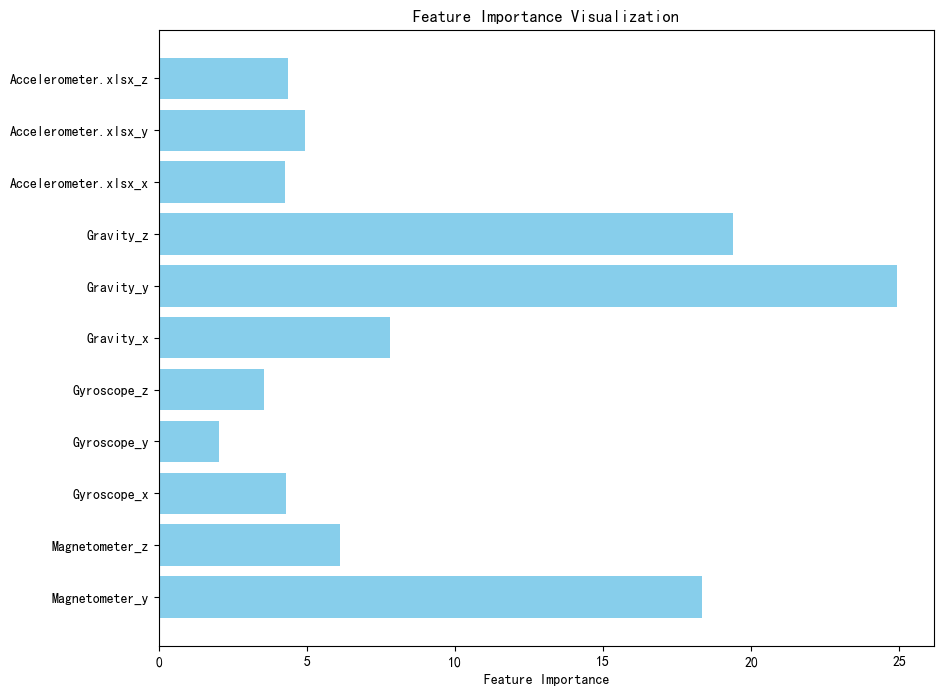

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 特征标签
feature_labels = ['Accelerometer.xlsx_z', 'Accelerometer.xlsx_y', 'Accelerometer.xlsx_x',
       'Gravity_z', 'Gravity_y', 'Gravity_x', 'Gyroscope_z', 'Gyroscope_y',
       'Gyroscope_x', 'Magnetometer_z', 'Magnetometer_y']

# 特征重要性
feature_importances = [4.36656169, 4.9274813,4.26237076, 19.37230824, 24.92758035,  7.8077476,
  3.56071269,  2.03110177,  4.28327771,  6.11731646, 18.34354141]

# 创建一个条形图
plt.figure(figsize=(10, 8))
indices = np.arange(len(feature_labels))
plt.barh(indices, feature_importances, color='skyblue')
plt.yticks(indices, feature_labels)
plt.xlabel('Feature Importance')
plt.title('Feature Importance Visualization')
plt.gca().invert_yaxis()  # 反转y轴，使得重要性最高的特征在上方

plt.show()

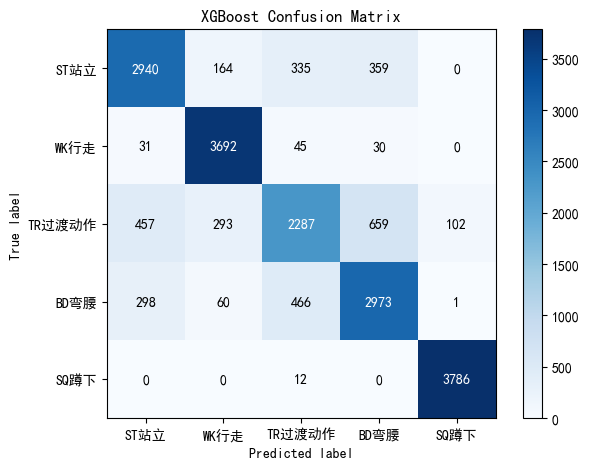

In [17]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plot_confusion_matrix(y_test, y_pred, ['ST站立', 'WK行走', 'TR过渡动作', 'BD弯腰', 'SQ蹲下'], 'XGBoost Confusion Matrix', 'XGBoost_Conclusion.png')

In [ ]:
feature_label = ['Accelerometer.xlsx_z_kd', 'Accelerometer.xlsx_y_kd',
       'Accelerometer.xlsx_x_kd', 'Gravity_z_kd', 'Gravity_y_kd',
       'Gravity_x_kd', 'Gyroscope_z_kd', 'Gyroscope_y_kd', 'Gyroscope_x_kd',
       'Magnetometer_z_kd', 'Magnetometer_y_kd', 'Magnetometer_x_kd', 'yaw_kd',
       'qx_kd', 'qz_kd', 'roll_kd', 'qw_kd', 'qy_kd', 'pitch_kd', 'Label_2_kd',
       'Accelerometer.xlsx_z_xd', 'Accelerometer.xlsx_y_xd',
       'Accelerometer.xlsx_x_xd', 'Gravity_z_xd', 'Gravity_y_xd',
       'Gravity_x_xd', 'Gyroscope_z_xd', 'Gyroscope_y_xd', 'Gyroscope_x_xd',
       'Magnetometer_z_xd', 'Magnetometer_y_xd', 'Magnetometer_x_xd', 'yaw_xd',
       'qx_xd', 'qz_xd', 'roll_xd', 'qw_xd', 'qy_xd', 'pitch_xd']



In [79]:
pd_X_test = pd.DataFrame(X_test,columns=feature_label)
pd_y_test = pd.DataFrame(y_test,columns=['label'])
pd_X_test

Accelerometer.xlsx_x_kd  Accelerometer.xlsx_y_kd  \
0                     -0.091652                -0.774333   
1                      0.060492                -0.686571   
2                      0.107479                -0.629816   
3                      0.104225                -0.572532   
4                      0.069106                -0.502790   
...                         ...                      ...   
724685                -0.038321                -0.005872   
724686                -0.044622                 0.005325   
724687                -0.056169                -0.009270   
724688                -0.051267                -0.012225   
724689                 0.003009                 0.021772   

        Accelerometer.xlsx_z_kd  Gravity_x_kd  Gravity_y_kd  Gravity_z_kd  \
0                     -0.660728     -9.503858     -2.402024     -0.278098   
1                     -0.653882     -9.504345     -2.400154     -0.277612   
2                     -0.615768     -9.505319     -2.396305     -0.277469   
3                     -0.575404     -9.506404     -2.391864     -0.278503   
4                     -0.522788     -9.507378     -2.387640     -0.281335   
...                         ...           ...           ...           ...   
724685                -0.032085     -8.679791      0.317955     -4.552861   
724686                -0.107455     -8.982932      0.678085     -3.874415   
724687                -0.029575     -8.677475      0.289014     -4.559407   
724688                -0.030834     -8.727993      1.045069     -4.347447   
724689                -0.061727     -7.841840     -1.407929     -5.717325   

        Gyroscope_x_kd  Gyroscope_y_kd  Gyroscope_z_kd  Magnetometer_x_kd  \
0            -0.050011        0.024321       -0.038968         -29.161255   
1            -0.022849        0.034795       -0.061955         -29.231964   
2            -0.000554        0.038268       -0.076908         -29.152059   
3             0.014356        0.036589       -0.085828         -29.093170   
4             0.027380        0.031228       -0.089959         -29.062024   
...                ...             ...             ...                ...   
724685        0.022313       -0.009104        0.031678         -67.458170   
724686        0.024398       -0.013121        0.040384         -64.172612   
724687        0.002525       -0.006057       -0.002437         -67.695193   
724688        0.004445       -0.001617       -0.003318         -65.380931   
724689        0.033192       -0.017136        0.067782         -61.872605   

        ...  Magnetometer_x_xd  Magnetometer_y_xd  Magnetometer_z_xd  \
0       ...          16.014099         -57.254448         -11.922226   
1       ...          15.966461         -57.164082         -11.856413   
2       ...          15.811198         -57.121332         -11.790099   
3       ...          15.660370         -57.028286         -11.732923   
4       ...          15.544727         -56.955111         -11.640393   
...     ...                ...                ...                ...   
724685  ...          13.739581         -62.007430          11.428153   
724686  ...          12.430217         -61.862004          15.485755   
724687  ...          10.823439         -55.190448          35.809353   
724688  ...          15.683735         -60.915648          20.152154   
724689  ...          17.950860         -56.744980          19.887518   

          yaw_xd     qx_xd     qz_xd   roll_xd     qw_xd     qy_xd  pitch_xd  
0       1.327859 -0.622519  0.088941 -2.773654 -0.294146  0.719748  0.516975  
1       1.330893 -0.623777  0.088091 -2.769418 -0.296451  0.717808  0.519347  
2       1.333582 -0.624944  0.087034 -2.764272 -0.299083  0.715810  0.521811  
3       1.336092 -0.626050  0.085833 -2.758985 -0.301667  0.713881  0.523973  
4       1.338646 -0.627118  0.084881 -2.754874 -0.303752  0.712154  0.525857  
...          ...       ...       ...       ...       ...       ...       ...  
724685  2.453934  0